# Bayesian Change-Points

- does online and offline detection. 
- the online is the adam,mckay 2007 method. 

http://nbviewer.jupyter.org/github/hildensia/bayesian_changepoint_detection/blob/master/Example%20Code.ipynb

Based on: 
- [1] Paul Fearnhead, Exact and Efficient Bayesian Inference for Multiple Changepoint problems, Statistics and computing 16.2 (2006), pp. 203--213
- [2] Xuan Xiang, Kevin Murphy, Modeling Changing Dependency Structure in Multivariate Time Series, ICML (2007), pp. 1055--1062
- [3] Ryan P. Adams, David J.C. MacKay, Bayesian Online Changepoint Detection, arXiv 0710.3742 (2007)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from __future__ import division
from functools import partial
import matplotlib.cm as cm
import pickle
import seaborn as sns
from keras.preprocessing import image

import bayesian_changepoint_detection.online_changepoint_detection as oncd
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from scipy.stats import multivariate_normal,t

import pandas as pd
import sys
sys.path.append('../')

from src import feature_extraction


%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Use scipy logsumexp().


## Testing on 1-D Generated Data

In [51]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*2 # new random mean 
        var = np.random.randn()*1 # new random variance 
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data

In [52]:
np.random.seed(1000)
data = generate_normal_time_series(7, 50, 200)

In [53]:
%time Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

CPU times: user 23.6 s, sys: 107 ms, total: 23.7 s
Wall time: 23.7 s


- prior over how likely it is to have two successive change-points. 
    - here they have a uniform prior over length of sequences. So seq len=1,=2,=3 etc. are all equally likely. 
    - I might want to use a poisson. 
- liklihood for data in run sequences (where there is no change-point)
    - here it's a guassian log lik model. 

In [ ]:
Pcp.shape # need to sum to get the probabilities. 

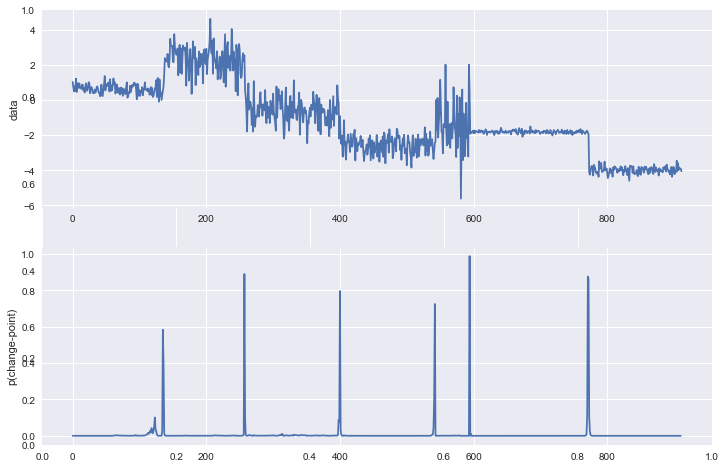

In [55]:
fig, ax = plt.subplots(figsize=[12,8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax.set_ylabel('data')
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))
ax.set_ylabel('p(change-point)')

In [56]:
import bayesian_changepoint_detection.online_changepoint_detection as oncd
reload(oncd)
%time R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.StudentT(0.1, .01, 1, 0))

CPU times: user 319 ms, sys: 6.42 ms, total: 325 ms
Wall time: 326 ms


- the online c.pd. is much faster because it loops through once and updates the probability of change-points. 


In [57]:
R.shape # are the probabilities over run-lengths

(913, 913)

/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


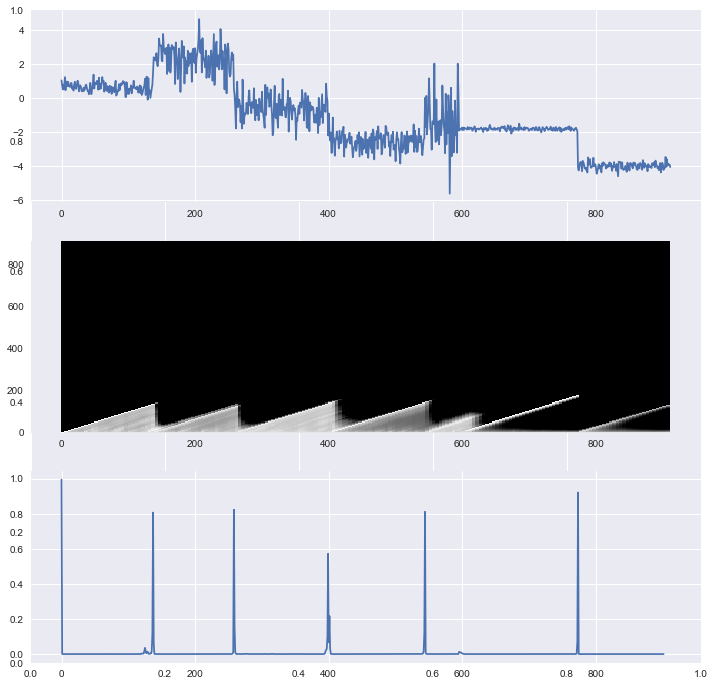

In [58]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=[12,12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data)
ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

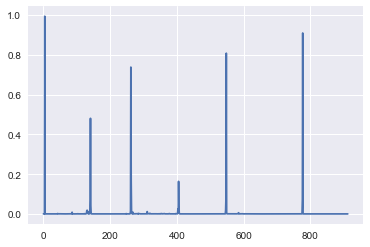

In [66]:
plt.plot(R[4,:])

## Testing on 2-D Generated Data

- generate new dataset

In [4]:
def generate_2D_normal_time_series(number_partitions, minl=50, maxl=1000,dim=2):
    partition = np.random.randint(minl, maxl, number_partitions)
    data = np.zeros((1,dim))
    for p in partition:
        mean = np.random.randn(dim)*2 # new random mean 
        Sigma = np.diag(np.ones(dim)).copy()
        tdata = multivariate_normal.rvs(mean, Sigma, size=p)
        data = np.vstack((data,tdata.copy()))
    data=data[1:,:]
    return data,partition.cumsum()[0:-1]


In [7]:
# generate data
np.random.seed(102) # this works 
data,partition = generate_2D_normal_time_series(3,10,100)


### Offline Method

In [22]:
Q, P, Pcp = offcd.offline_changepoint_detection(data, partial(offcd.const_prior, l=(len(data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)

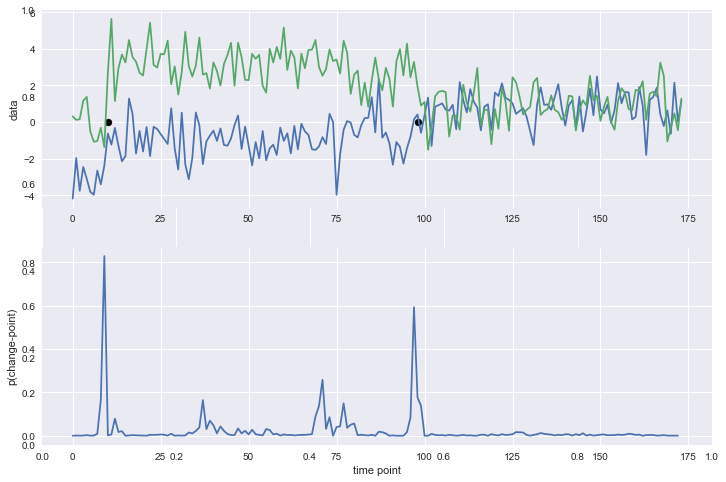

In [31]:
fig, ax = plt.subplots(figsize=[12,8])

ax = fig.add_subplot(2, 1, 1)
ax.plot(data[:])
ax.scatter(partition,np.zeros(len(partition)),c='k') # change points 
ax.set_ylabel('data')
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp).sum(0))
ax.set_ylabel('p(change-point)')
ax.set_xlabel('time point')

### Online Method (adapted by chris for multiple dimensions)

In [23]:
# fit model 
R, maxes = oncd.online_changepoint_detection(data, partial(oncd.constant_hazard, 250), oncd.MV_Norm(mu=np.zeros(2),Sigma=np.diag(np.ones(2)),n=np.array([1.0])))
# sometimes need to re-run because of underflow? there are inf's that appear 

In [24]:
R

array([[  1.00000000e+00,   4.00000000e-03,   4.00000000e-03, ...,
          4.00000000e-03,   4.00000000e-03,   4.00000000e-03],
       [  0.00000000e+00,   9.96000000e-01,   3.98400000e-03, ...,
          1.08484064e-03,   1.23774557e-02,   1.07295785e-03],
       [  0.00000000e+00,   0.00000000e+00,   9.92016000e-01, ...,
          8.33851970e-04,   2.46604558e-04,   1.71260033e-03],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   2.67558967e-84,   1.42027863e-86],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   8.79588576e-85],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


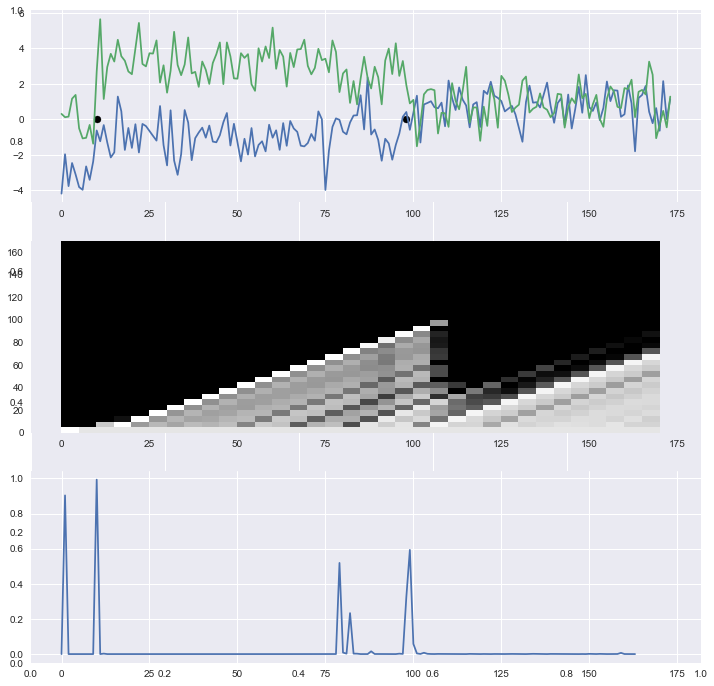

In [25]:
# Plot 
fig, ax = plt.subplots(figsize=[12,12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data) # time series 
ax.scatter(partition,np.zeros(len(partition)),c='k') # change points 


ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 5  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)

ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=10;
ax.plot(R[Nw,Nw:-1])

### Online Method (estimating Sigma)

In [158]:
# generate data
np.random.seed(105) # this works 
data,partition = generate_2D_normal_time_series(3,10,100)


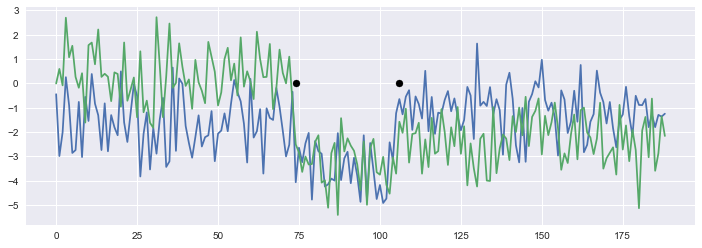

In [159]:
fig, ax = plt.subplots(figsize=[12,4])
ax.plot(data) # time series 
ax.scatter(partition,np.zeros(len(partition)),c='k') # change points 


In [169]:
import bayesian_changepoint_detection.online_changepoint_detection_v2 as oncd2
reload(oncd2)
#import bayesian_changepoint_detection.offline_changepoint_detection as offcd

<module 'bayesian_changepoint_detection.online_changepoint_detection_v2' from '/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/bayesian_changepoint_detection/online_changepoint_detection_v2.pyc'>

In [170]:
# fit model 
R, maxes = oncd2.online_changepoint_detection(data, partial(oncd2.constant_hazard, 250), oncd2.MV_Norm(mu=np.zeros(2),Sigma=np.diag(np.ones(2)),n=np.array([1.0])))
# sometimes need to re-run because of underflow? there are inf's that appear 

/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


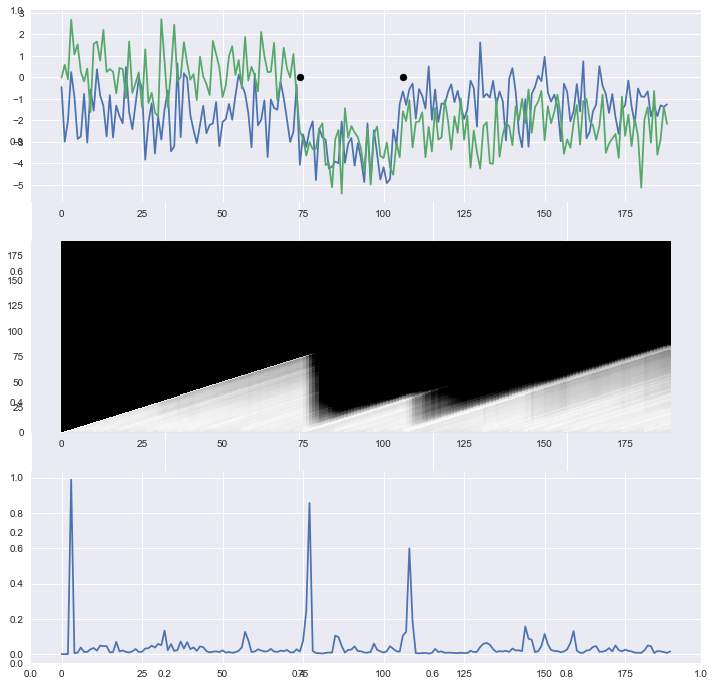

In [188]:
# Plot 
fig, ax = plt.subplots(figsize=[12,12])
ax = fig.add_subplot(3, 1, 1)
ax.plot(data) # time series 
ax.scatter(partition,np.zeros(len(partition)),c='k') # change points 


ax = fig.add_subplot(3, 1, 2, sharex=ax)
sparsity = 1  # only plot every fifth data for faster display
ax.pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)

ax = fig.add_subplot(3, 1, 3, sharex=ax)
Nw=0;
ax.plot(R[3,:])

In [189]:
#R[3,:]

### Offline Method Full Covariance Estimation

In [248]:
import bayesian_changepoint_detection.generate_data as gd

In [253]:
partition, data = gd.generate_xuan_motivating_example(100,200)

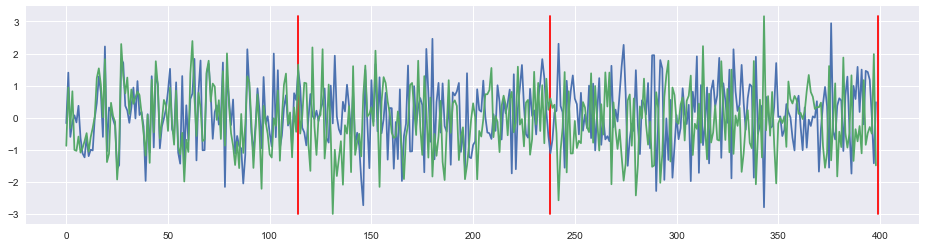

In [254]:
changes = np.cumsum(partition)

fig, ax = plt.subplots(figsize=[16, 4])
for p in changes:
  ax.plot([p,p],[np.min(data),np.max(data)],'r')
for d in range(2):
  ax.plot(data[:,d])

In [255]:
data.shape

(399, 2)

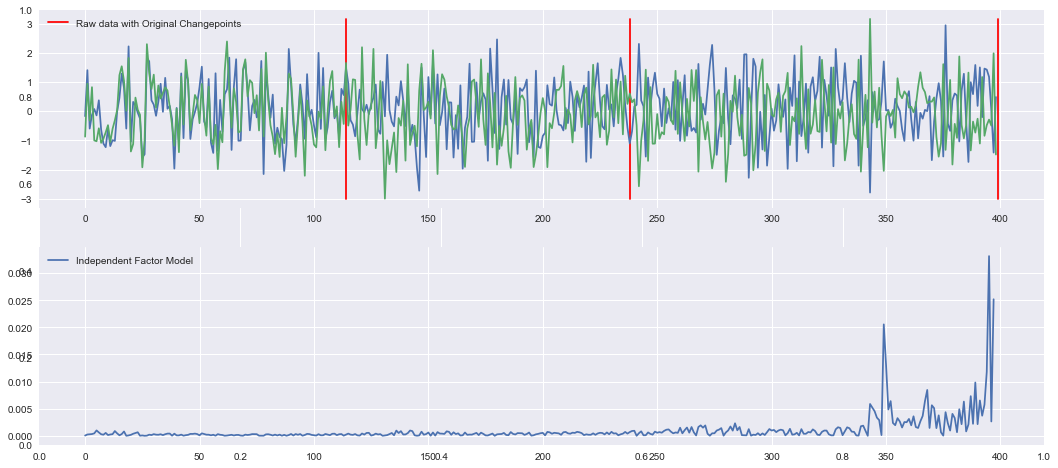

In [256]:
import bayesian_changepoint_detection.offline_changepoint_detection as offcd
from functools import partial

Q_ifm, P_ifm, Pcp_ifm = offcd.offline_changepoint_detection(data,partial(offcd.const_prior, l=(len(data)+1)),offcd.ifm_obs_log_likelihood,truncate=-20)

fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(2, 1, 1)
for p in changes:
  ax.plot([p,p],[np.min(data),np.max(data)],'r')
for d in range(2):
  ax.plot(data[:,d])
plt.legend(['Raw data with Original Changepoints'])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp_ifm).sum(0))
plt.legend(['Independent Factor Model'])
plt.show()

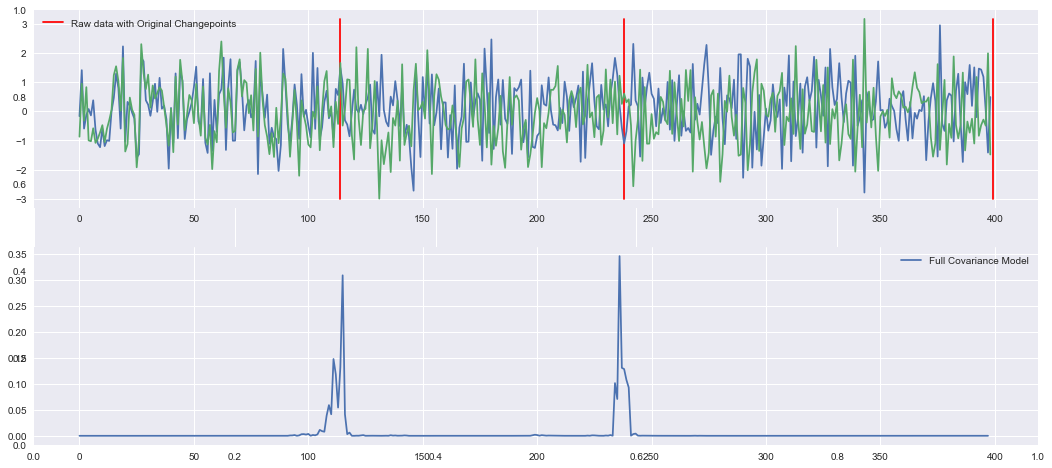

In [257]:

Q_full, P_full, Pcp_full = offcd.offline_changepoint_detection(data,partial(offcd.const_prior, l=(len(data)+1)),offcd.fullcov_obs_log_likelihood, truncate=-20)

fig, ax = plt.subplots(figsize=[18, 8])
ax = fig.add_subplot(2, 1, 1)
for p in changes:
  ax.plot([p,p],[np.min(data),np.max(data)],'r')
for d in range(2):
  ax.plot(data[:,d])
plt.legend(['Raw data with Original Changepoints'])
ax = fig.add_subplot(2, 1, 2, sharex=ax)
ax.plot(np.exp(Pcp_full).sum(0))
plt.legend(['Full Covariance Model'])
plt.show()

## Testing on black dress - white dress

In [5]:
# get features for 2 folders 
feature_list_black_imgs = feature_extraction.layer_feature_extraction('../data_img_classes/class_black/')
feature_list_white_imgs = feature_extraction.layer_feature_extraction('../data_img_classes/class_white/')

K.image_dim_ordering: tf
/Users/chris/Desktop/CDIPS_Recommender/notebooks/../data_img_classes/class_black//*.jpg
K.image_dim_ordering: tf
/Users/chris/Desktop/CDIPS_Recommender/notebooks/../data_img_classes/class_white//*.jpg


In [6]:
# concatenate features into a vector (black dresses first, then white dresses)
n_blk_imgs = len(feature_list_black_imgs.keys())
n_white_imgs = len(feature_list_white_imgs.keys())
feature_vec = np.empty((n_blk_imgs+n_white_imgs,2048))
img_files = []
for i,img_file in enumerate(feature_list_black_imgs.keys()+feature_list_white_imgs.keys()):
    if i<n_blk_imgs:
        feature_vec[i,:]=feature_list_black_imgs[img_file]
    else:
        feature_vec[i,:]=feature_list_white_imgs[img_file]
    img_files.append(img_file)
feature_vec.shape

(51, 2048)

In [7]:
n_blk_imgs

23

In [8]:
# reduce dimensionality 
pca_all = pickle.load(open('../data_nn_features/pca_all_items_sample1000.pkl','rb'))

In [9]:
projected_feature_vec = pca_all.transform(feature_vec)
print(projected_feature_vec.shape)



(51, 2048)


### Plotting the dress sequence

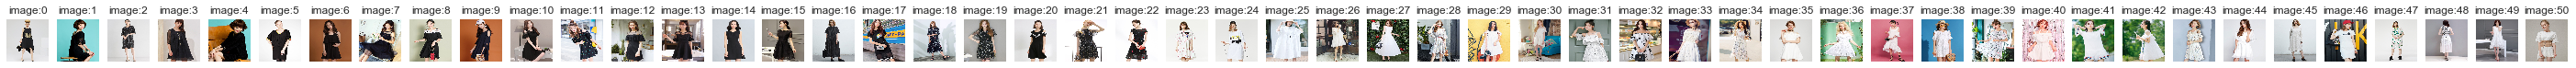

In [11]:
fig,axes =plt.subplots(1,len(img_files),figsize=(50,4))
for i,img_file in enumerate(img_files):
    img = image.load_img(img_file, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].set_title('image:'+str(i))
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.savefig('../figures/bw_sequence_all.png',dpi=300)

- The dresses switch from black to white at image 22-23

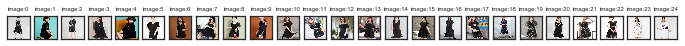

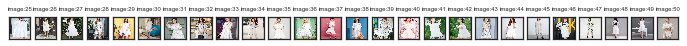

In [64]:
fig,axes =plt.subplots(1,len(img_files[0:25]),figsize=(12,2))
for i,img_file in enumerate(img_files[0:25]):
    img = image.load_img(img_file, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].set_title('image:'+str(i),fontsize=6)
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.savefig('../figures/bw_sequence_1_25.png',dpi=300)

fig,axes =plt.subplots(1,len(img_files[25::]),figsize=(12,2))
for i,img_file in enumerate(img_files[25::]):
    img = image.load_img(img_file, target_size=(224, 224))
    axes[i].imshow(img)
    axes[i].set_title('image:'+str(i+25),fontsize=6)
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
plt.savefig('../figures/bw_sequence_25_50.png',dpi=300)

### Offline Method

In [78]:
reduced_projected_feature_vec = projected_feature_vec[:,0:5] 
print(reduced_projected_feature_vec.shape)
input_data=reduced_projected_feature_vec
Q, P, Pcp = offcd.offline_changepoint_detection(input_data, partial(offcd.const_prior, l=(len(input_data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)


(51, 5)


(0, 51)

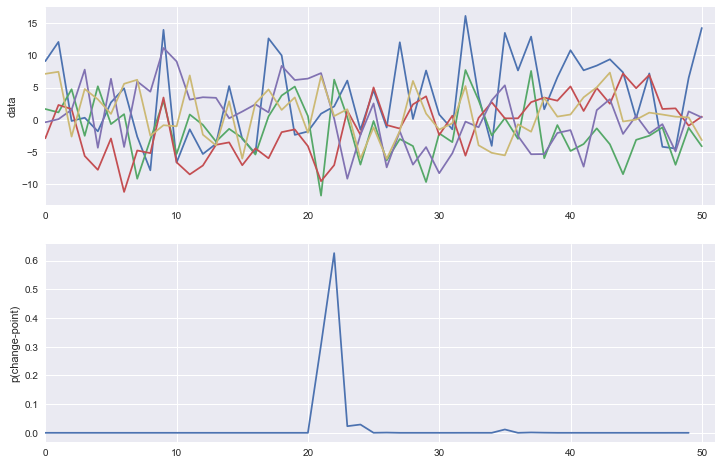

In [79]:
fig, ax = plt.subplots(2,1,figsize=[12,8])

ax[0].plot(input_data[:])
ax[0].set_ylabel('data')
ax[0].set_xlim(0,input_data.shape[0])

ax[1].plot(np.exp(Pcp).sum(0))
ax[1].set_ylabel('p(change-point)')
ax[1].set_xlim(0,input_data.shape[0])

In [82]:
print('change point at image {0}').format(np.argmax(np.exp(Pcp).sum(0)))

change point at image 22


- with 5 PC's, the algorithm picks up the switch from black dresses to white dresses.  

In [73]:
reduced_projected_feature_vec = projected_feature_vec[:,0:50] 
print(reduced_projected_feature_vec.shape)
input_data=reduced_projected_feature_vec
Q, P, Pcp = offcd.offline_changepoint_detection(input_data, partial(offcd.const_prior, l=(len(input_data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)


(51, 50)


(0, 51)

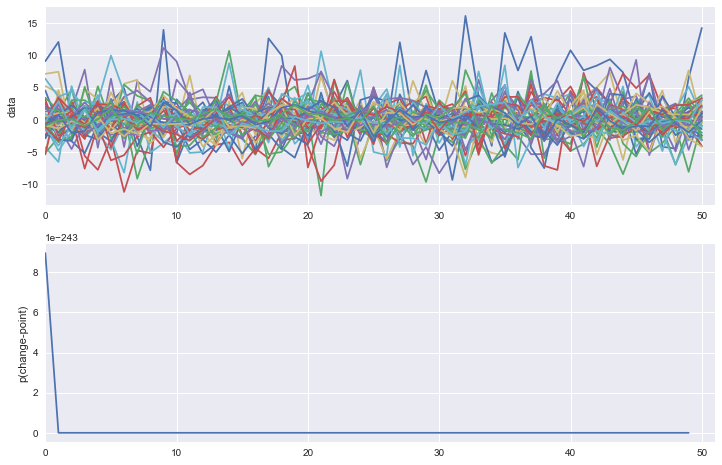

In [74]:
fig, ax = plt.subplots(2,1,figsize=[12,8])

ax[0].plot(input_data[:])
ax[0].set_ylabel('data')
ax[0].set_xlim(0,input_data.shape[0])

ax[1].plot(np.exp(Pcp).sum(0))
ax[1].set_ylabel('p(change-point)')
ax[1].set_xlim(0,input_data.shape[0])

- with too many PC's, the method fails. 

### Online Method (McKay 2007)

In [209]:
reduced_projected_feature_vec = projected_feature_vec[:,0:50] 
print(reduced_projected_feature_vec.shape)
input_data = reduced_projected_feature_vec
R, maxes = oncd.online_changepoint_detection(input_data, partial(oncd.constant_hazard, 250), oncd.MV_Norm(mu=np.zeros(input_data.shape[1]),Sigma=np.diag(np.ones(input_data.shape[1])),n=np.array([1.0])))
# sometimes have to run this twice due to underflow issues

(51, 50)


/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


(0, 51)

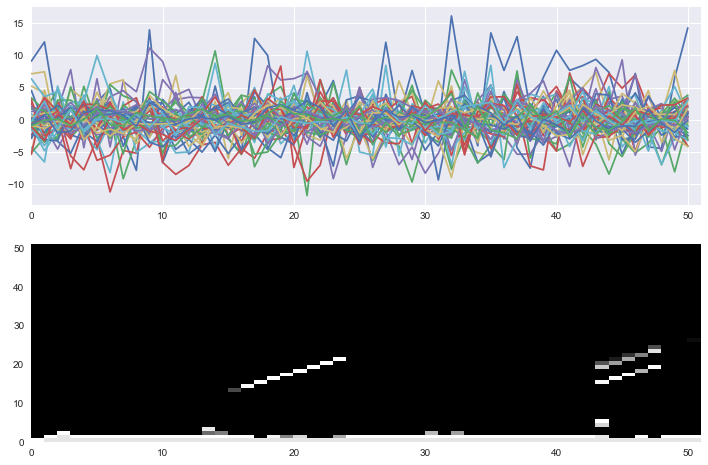

In [210]:
# Plot 
fig, ax = plt.subplots(2,1,figsize=[12,8])

ax[0].plot(input_data) # time series 
ax[0].set_xlim(0,input_data.shape[0])


sparsity = 1  # only plot every fifth data for faster display
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax[1].set_xlim(0,input_data.shape[0])

# ax = fig.add_subplot(3, 1, 3, sharex=ax)
# Nw=5;
# ax.plot(R[Nw,Nw:-1])

- here the algorithm estimate that at image 23, there is a 23 image run length with high probability. 
- at image 24 the probability of the run length drops back to 1. 
- this algorithm does better with the higher dimensional input 

In [211]:
reduced_projected_feature_vec = projected_feature_vec[:,0:5] 
print(reduced_projected_feature_vec.shape)
input_data = reduced_projected_feature_vec
R, maxes = oncd.online_changepoint_detection(input_data, partial(oncd.constant_hazard, 250), oncd.MV_Norm(mu=np.zeros(input_data.shape[1]),Sigma=np.diag(np.ones(input_data.shape[1])),n=np.array([1.0])))
# sometimes have to run this twice due to underflow issues

(51, 5)


/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


(0, 51)

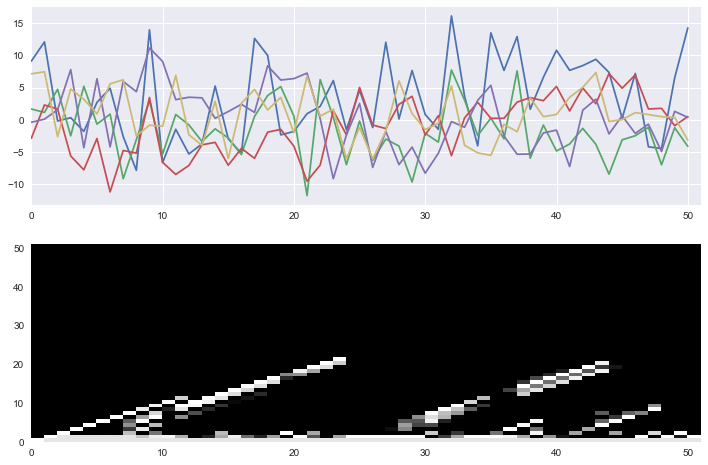

In [212]:
# Plot 
fig, ax = plt.subplots(2,1,figsize=[12,8])

ax[0].plot(input_data) # time series 
ax[0].set_xlim(0,input_data.shape[0])


sparsity = 1  # only plot every fifth data for faster display
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax[1].set_xlim(0,input_data.shape[0])

# ax = fig.add_subplot(3, 1, 3, sharex=ax)
# Nw=5;
# ax.plot(R[Nw,Nw:-1])

- though it appears to do better in with 5 top PC's (hard to tell). 


### Online Method (McKay 2007) - sigma estimation

In [219]:
import bayesian_changepoint_detection.online_changepoint_detection_v2 as oncd2
reload(oncd2)

<module 'bayesian_changepoint_detection.online_changepoint_detection_v2' from '/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/bayesian_changepoint_detection/online_changepoint_detection_v2.pyc'>

In [220]:
reduced_projected_feature_vec = projected_feature_vec[:,0:5] 
print(reduced_projected_feature_vec.shape)
input_data = reduced_projected_feature_vec

R, maxes = oncd2.online_changepoint_detection(input_data, partial(oncd2.constant_hazard, 250), oncd2.MV_Norm(mu=np.zeros(input_data.shape[1]),Sigma=np.diag(np.ones(input_data.shape[1])),n=np.array([1.0])))
# sometimes need to re-run because of underflow? there are inf's that appear 

(51, 5)


/Users/chris/anaconda/envs/virtenv/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


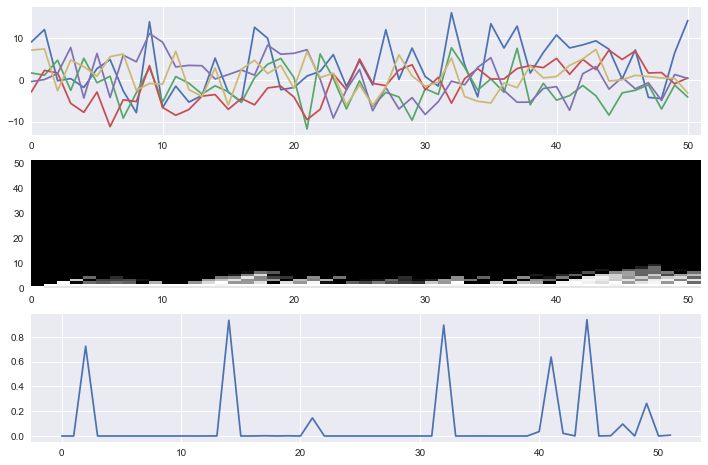

In [230]:
# Plot 
fig, ax = plt.subplots(3,1,figsize=[12,8])

ax[0].plot(input_data) # time series 
ax[0].set_xlim(0,input_data.shape[0])


sparsity = 1  # only plot every fifth data for faster display
ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
          np.array(range(0, len(R[:,0]), sparsity)), 
          -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
          cmap=cm.Greys, vmin=0, vmax=30)
ax[1].set_xlim(0,input_data.shape[0])

ax[2].plot(R[2,:])

### Offline Full Covariance

In [54]:
reduced_projected_feature_vec = projected_feature_vec[:,0:50] 
print(reduced_projected_feature_vec.shape)
data=reduced_projected_feature_vec
Q_full, P_full, Pcp_full = offcd.offline_changepoint_detection(data,partial(offcd.const_prior, l=(len(data)+1)),offcd.fullcov_obs_log_likelihood, truncate=-20)


(51, 50)


In [55]:
data.shape

(51, 50)

In [56]:
Pcp_full.shape

(50, 50)

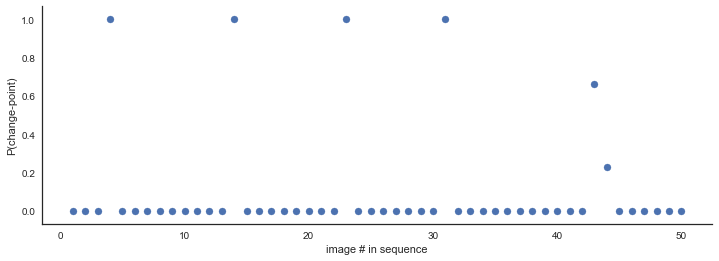

In [59]:
plt.figure(figsize=(12,4))
import seaborn as sns
sns.set_style('white')
plt.scatter(np.arange(data.shape[0]-1)+1,np.exp(Pcp_full).sum(0))
plt.ylabel('P(change-point)')
plt.xlabel('image # in sequence')
sns.despine()
plt.savefig('../figures/cp_detection_bw_seq.png',dpi=300)

## Plot change-points for our example sequences

In [65]:
# load an example trajectory 
folder='../data_img_sample_item_view_sequences/'
from src.data_management import get_meta_data_from_sequence_data
df = get_meta_data_from_sequence_data(folder)
df.head()


,user_id,view_position,spu,view_seconds,tag,jpg
0,1026336619,10,18935327703625752,30,view,.jpg
1,1026336619,11,225819416539443204,8,view,.jpg
2,1026336619,12,452688254114283543,7,view,.jpg
3,1026336619,13,308854529632018448,14,view,.jpg
4,1026336619,14,323209760887509007,13,view,.jpg


In [66]:
# get pca
pca_all = pickle.load(open('../data_nn_features/pca_all_items_sample1000.pkl','rb'))

In [67]:
def sort_feature_list_keys(feature_list):
    return(list(np.array(feature_list.keys())[np.argsort(np.array([int(key.split('_')[-5]) for key in feature_list.keys()]))]))

In [68]:
def change_point_per_user(user_id,pca_all,n_PCs=100):
    
    #print('extracting')
    # extract features per user 
    feature_list= feature_extraction.layer_feature_extraction('../data_img_sample_item_view_sequences/',filter='*'+user_id+'*')

    # sort by view order
    feature_file_list = sort_feature_list_keys(feature_list)

    # convert to matrix
    n_imgs =len(feature_list)
    feature_vec = np.empty((n_imgs,2048))
    img_files = []
    for i,img_file in enumerate(feature_file_list):
        feature_vec[i,:]=feature_list[img_file]
        img_files.append(img_file)

    # pca transform 
    projected_feature_vec = pca_all.transform(feature_vec)

    # reduce dimensionality 
    reduced_projected_feature_vec = projected_feature_vec[:,0:n_PCs] 


    # change-point method 1
    input_data = reduced_projected_feature_vec

    Q, P, Pcp = offcd.offline_changepoint_detection(input_data,partial(offcd.const_prior, l=(len(input_data)+1)),offcd.fullcov_obs_log_likelihood, truncate=-20)
    #Q, P, Pcp = offcd.offline_changepoint_detection(input_data, partial(offcd.const_prior, l=(len(input_data)+1)), offcd.gaussian_obs_log_likelihood, truncate=-40)
    
    # change-point method online (with covariance )
    #R, maxes = oncd2.online_changepoint_detection(input_data, partial(oncd2.constant_hazard, 250), oncd2.MV_Norm(mu=np.zeros(input_data.shape[1]),Sigma=np.diag(np.ones(input_data.shape[1])),n=np.array([1.0])))
    #R, maxes = oncd.online_changepoint_detection(input_data, partial(oncd.constant_hazard, 250), oncd.MV_Norm(mu=np.zeros(input_data.shape[1]),Sigma=np.diag(np.ones(input_data.shape[1])),n=np.array([1.0])))
    R=0
    
    return(R,Pcp,img_files)


In [69]:
def plot_image_sequence(img_files,user_id,show=True):
    fig,axes =plt.subplots(1,len(img_files),figsize=(50,4))
    for i,img_file in enumerate(img_files):
        img = image.load_img(img_file, target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].set_title('image:'+str(i))
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    plt.savefig('../figures/img_sequences/seq_'+user_id+'.png',dpi=300)
    if show==False:
        plt.close()

In [70]:
def plot_change_points(R,PcP,show=True):
    
    fig, ax = plt.subplots(3,1,figsize=[12,8])
    n = Pcp.shape[0]
    ax[0].scatter(np.arange(n),np.exp(Pcp).sum(0))
    #ax[0].plot(np.exp(Pcp).sum(0))
    ax[0].set_ylabel('p(change-point)')
    ax[0].set_xlim(0,n)
    ax[0].set_title('Offline Method')              
                       
#     sparsity = 1  # only plot every fifth data for faster display
#     ax[1].pcolor(np.array(range(0, len(R[:,0]), sparsity)), 
#               np.array(range(0, len(R[:,0]), sparsity)), 
#               -np.log(R[0:-1:sparsity, 0:-1:sparsity]), 
#               cmap=cm.Greys, vmin=0, vmax=30)
#     ax[1].set_xlim(0,R.shape[0])

#     diff_in_max = np.abs(np.diff(np.argmax(R,axis=0)))
#     expected_run_len = np.dot(R.T,np.arange(len(R)))

#     #Nw=5;
#     #ax[2].plot(R[Nw,Nw:-1])
#     ax[2].plot(diff_in_max,label='drop in max run length')
#     ax[2].plot(expected_run_len,label='expected run length')
#     ax[2].set_title('Online Method')
#     ax[2].set_xlim(0,R.shape[0])
#     plt.legend()
    #plt.savefig('../figures/img_sequences/seq_'+user_id+'_cp_predictions_v1.png',dpi=300)
    if show==False:
        plt.close()

In [71]:
user_ids = df.user_id.unique()
user_ids[0:5]

array(['1026336619', '106144465', '1201108847', '1254629014', '1259361786'], dtype=object)

#### Example User

In [72]:

user_id=user_ids[12] # looks reasonable. 



In [73]:
R,Pcp,img_files = change_point_per_user(user_id,pca_all)

K.image_dim_ordering: tf
/Users/chris/Desktop/CDIPS_Recommender/notebooks/../data_img_sample_item_view_sequences/*1538001568**.jpg


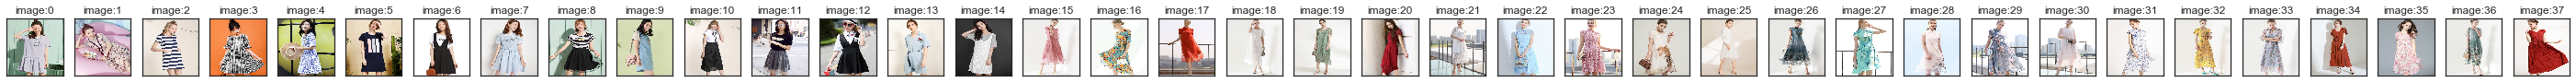

In [74]:
plot_image_sequence(img_files,user_id)

In [75]:
len(img_files)

38

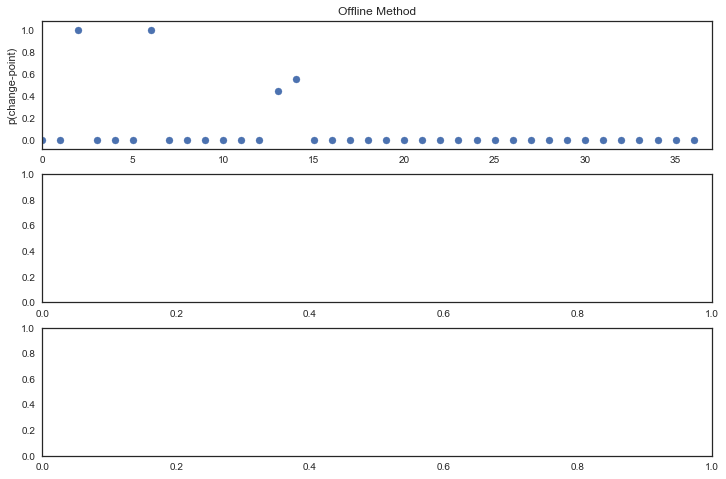

In [76]:
plot_change_points(R,Pcp)

## Plot change-points for people in dataset without images 

- see how often it is suggesting a change 



In [2]:
# requires nn features 
spu_fea = pd.read_pickle("../data_nn_features/spu_fea_sample1000.pkl")

In [3]:
# load pca
pca = pickle.load(open('../data_nn_features/pca_all_items_sample1000.pkl','rb'))

In [5]:
# load smaller user behavior dataset
user_profile = pd.read_pickle('../data_user_view_buy/user_profile_items_nonnull_features_20_mins_5_views_v2_sample1000.pkl')
user_sample = user_profile.user_id.unique()
print(len(user_profile))
print(len(user_sample))
user_profile.head()


40141
961


,user_id,buy_spu,buy_sn,buy_ct3,view_spu,view_sn,view_ct3,time_interval,view_cnt,view_seconds,index,spu_id,view_spu_count,drop
1226,3787002243,14994645517246498,10006541,334,221597279072104476,10005949,334,389705,4,98,87616.0,2.215973e+17,11,0
1227,3787002243,14994645517246498,10006541,334,29349802448457744,10004542,334,7342,1,10,73880.0,2.934980e+16,11,0
2261,132681117,6831894477217820,10001155,334,27661017974767638,10004048,334,32451,1,6,21676.0,2.766102e+16,63,0
2262,132681117,6831894477217820,10001155,334,288869796837830741,10000351,334,33318,2,30,6475.0,2.888698e+17,63,0
2263,132681117,6831894477217820,10001155,334,301817675098247170,10020640,334,428149,1,9,25612.0,3.018177e+17,63,0


In [25]:
import sys 
sys.path.append('../')
import src
import src.recommendation_v2
reload(src.recommendation_v2)
from src.recommendation_v2 import *


In [26]:
extra_inputs={'pca':pca}
extra_inputs['dr_params']={'method':'PCA','ndims':50}
#extra_inputs['cp_params']={'method':'Online'}
extra_inputs['cp_params']={'method':'Offline'}

user_id = np.random.choice(user_sample,size=1)[0]
user_id = user_sample[10]
user = User(user_id,user_profile,spu_fea,extra_inputs=extra_inputs)
user.create_candidates()
user.rank_candidates(method='AverageFeatureSim_withinSegments')



In [15]:
#np.std(user.feature_by_time_matrix_reduced[:,0])

In [17]:
# fig,axes = plt.subplots(3,1,figsize=(8,6))
# n = user.feature_by_time_matrix_reduced.shape[0]
# axes[0].plot(user.feature_by_time_matrix_reduced)
# axes[0].set_xlim([0,n])


# axes[1].pcolor(np.array(range(0, len(user.R[:,0]), 1)), 
#               np.array(range(0, len(user.R[:,0]), 1)), 
#               -np.log(user.R[0:-1:1, 0:-1:1]), 
#               cmap=cm.Greys, vmin=0, vmax=30)
# axes[1].set_xlim([0,n])
# #axes[2].scatter(np.arange(n),user.change_points,s=10)
# axes[2].plot(user.expected_run_len)
# axes[2].plot(user.diff_in_max)
# axes[2].set_xlim([0,n])

In [16]:
#import scipy as sp
#plt.plot(sp.stats.multivariate_normal.rvs(mean=[0],cov=4.0,size=100))

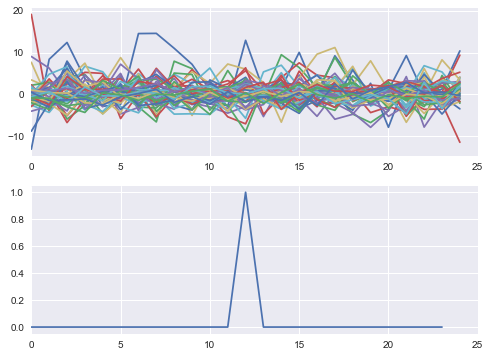

In [18]:
fig,axes = plt.subplots(2,1,figsize=(8,6))
n = user.feature_by_time_matrix_reduced.shape[0]
axes[0].plot(user.feature_by_time_matrix_reduced)
axes[0].set_xlim([0,n])

axes[1].set_xlim([0,n])
#axes[2].scatter(np.arange(n),user.change_points,s=10)
axes[1].plot(user.cp_prob)

In [92]:
#len(user.feature_by_time_matrix_reduced)

### Number of Change-Points per User

AverageFeatureSim_AfterChangePoint
getting feature sequence
reducing feature dimensions (pca)
estimating change points
no change points
scoring candidates
AverageFeatureSim_AfterChangePoint
getting feature sequence
reducing feature dimensions (pca)
estimating change points
scoring candidates
AverageFeatureSim_AfterChangePoint
getting feature sequence
reducing feature dimensions (pca)
estimating change points
scoring candidates
AverageFeatureSim_AfterChangePoint
getting feature sequence
reducing feature dimensions (pca)
estimating change points
no change points
scoring candidates
AverageFeatureSim_AfterChangePoint
getting feature sequence
reducing feature dimensions (pca)
estimating change points
no change points
scoring candidates
AverageFeatureSim_AfterChangePoint
getting feature sequence
reducing feature dimensions (pca)
estimating change points
no change points
scoring candidates
AverageFeatureSim_AfterChangePoint
getting feature sequence
reducing feature dimensions (pca)
estimating

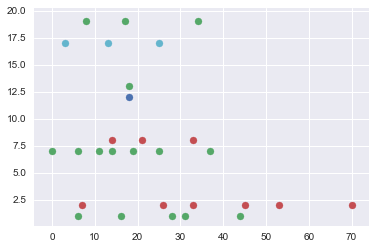

In [21]:
num_change_points_per_user = np.array([])
extra_inputs={'pca':pca}
extra_inputs['dr_params']={'method':'PCA','ndims':50}
extra_inputs['cp_params']={'method':'Offline'}

for ui,user_id in enumerate(np.random.choice(user_sample,size=20)):
    user = User(user_id,user_profile,spu_fea,extra_inputs=extra_inputs)
    user.create_candidates()
    user.rank_candidates(method='AverageFeatureSim_AfterChangePoint')
    x = np.where(user.change_points==1)[0]
    plt.scatter(x,np.ones(len(x))*ui)
    num_change_points_per_user= np.append(num_change_points_per_user,len(x))

In [22]:
np.sum(num_change_points_per_user==0)

12

(array([ 12.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.   ,  0.175,  0.35 ,  0.525,  0.7  ,  0.875,  1.05 ,  1.225,
         1.4  ,  1.575,  1.75 ,  1.925,  2.1  ,  2.275,  2.45 ,  2.625,
         2.8  ,  2.975,  3.15 ,  3.325,  3.5  ,  3.675,  3.85 ,  4.025,
         4.2  ,  4.375,  4.55 ,  4.725,  4.9  ,  5.075,  5.25 ,  5.425,
         5.6  ,  5.775,  5.95 ,  6.125,  6.3  ,  6.475,  6.65 ,  6.825,  7.   ]),
 <a list of 40 Patch objects>)

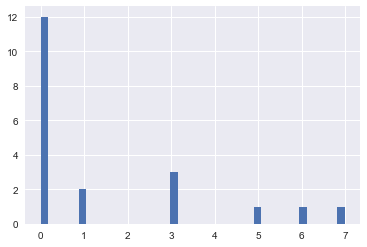

In [23]:
plt.hist(num_change_points_per_user,bins=40)

## Cropped Images

In [336]:
reload(feature_extraction)

<module 'src.feature_extraction' from '../src/feature_extraction.pyc'>

In [337]:
# extract features for seqeunce
feature_list= feature_extraction.layer_feature_extraction('../data_img_cropped_seq2')

# convert to list
feature_file_list = list(feature_list)

# convert to matrix
n_imgs =len(feature_list)
feature_vec = np.empty((n_imgs,2048))
img_files = []
for i,img_file in enumerate(feature_file_list):
    feature_vec[i,:]=feature_list[img_file]
    img_files.append(img_file)


K.image_dim_ordering: tf


../src/feature_extraction.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("av..., inputs=Tensor("in...)`
  output=base_model.get_layer(layer_name).output)


/Users/chris/Desktop/CDIPS_Recommender/notebooks/../data_img_cropped_seq2/*.jpg


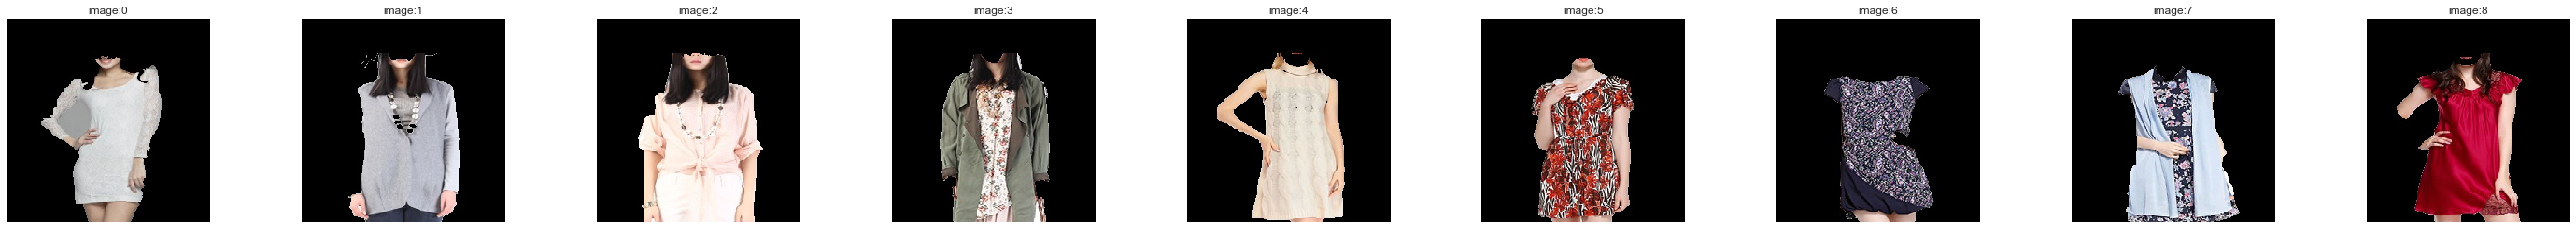

In [338]:
def plot_image_sequence(img_files,show=True):
    fig,axes =plt.subplots(1,len(img_files),figsize=(50,4))
    for i,img_file in enumerate(img_files):
        img = image.load_img(img_file, target_size=(224, 224))
        axes[i].imshow(img)
        axes[i].set_title('image:'+str(i))
        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_visible(False)
    #plt.savefig('../figures/img_sequences/seq_'+user_id+'.png',dpi=300)
    if show==False:
        plt.close()
plot_image_sequence(img_files)

In [339]:
feature_vec.shape

(9, 2048)

In [342]:
# pca transform 
projected_feature_vec = pca_all.transform(feature_vec)

# reduce dimensionality 
reduced_projected_feature_vec = projected_feature_vec[:,0:100] 


# change-point method 1
input_data = reduced_projected_feature_vec 
input_data=feature_vec

Q, P, Pcp = offcd.offline_changepoint_detection(input_data,partial(offcd.const_prior, l=(len(input_data)+1)),offcd.fullcov_obs_log_likelihood, truncate=-20)

In [345]:
#


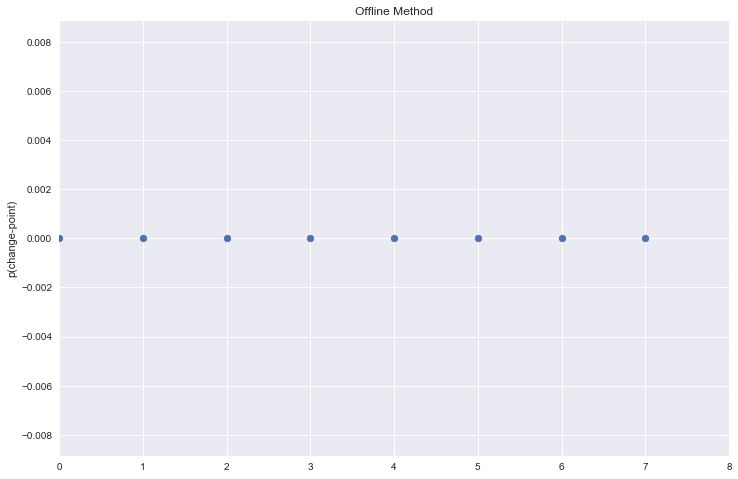

In [343]:
fig, ax = plt.subplots(1,1,figsize=[12,8])
n = Pcp.shape[0]
ax.scatter(np.arange(n),np.exp(Pcp).sum(0))
ax.set_ylabel('p(change-point)')
ax.set_xlim(0,n)
ax.set_title('Offline Method')    

# Save

In [190]:
%%bash 
jupyter nbconvert --to html Change_Point_Detection_in_Trajectories.ipynb && mv Change_Point_Detection_in_Trajectories.html ../notebook_htmls/Change_Point_Detection_in_Trajectories_v3.html
cp Change_Point_Detection_in_Trajectories.ipynb ../notebook_versions/Change_Point_Detection_in_Trajectories_v3.ipynb

[NbConvertApp] Converting notebook Change_Point_Detection_in_Trajectories.ipynb to html
[NbConvertApp] Writing 2678873 bytes to Change_Point_Detection_in_Trajectories.html
